# DCGAN with attribute
## Architecture:
* <b>image size: (H, W): from (218, 178) to (32, 32)</b>
* <b>Generator:</b> 1 FC + 4 deconv layer <br>
    [**(data)**+**(attr)**] 
    -> [FC] -> flatten -> BN1 -> lReLU1  <br>
    ->[Decv2] -> BN2 -> lReLU2 <br>
    ->[Decv3] -> BN3 -> lReLU3 <br>
    ->[Decv4] -> sigmoid<br>
* <b>Discriminator:</b>4 conv layer + 1 FC layer <br>
    [**(data)**] 
    ->[Conv1] -> lReLU1 -> <br>
    ->[Conv2] -> BN2 -> lReLU2 <br>
    ->[Conv3] -> BN3 -> lReLU3 <br>
    ->flatten + **(attr)** -> [FC]<br>

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.misc
import pandas as pd
import os
import math
%matplotlib inline

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

batchsize = 32
num_of_img = 20000
Z_dim = 100  # noize dim
X_dim = 116412 # 178 * 218 * 3
y_dim = 23 # total attr dim
h_dim = 128 # last FC hidden layer

H_ = 32 
W_ = 32 


### det directory
OUTPUT_DIR = 'o_1126_interactive_20k/'
MODEL_DIR = 'model1126_20k/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data preprocessing
* helper function for risizee image
* load data & attr
* choose choose specific features for observation

In [2]:
def center_crop(x, crop_h, crop_w,
                resize_h=64, resize_w=64):
    if crop_w is None:
        crop_w = crop_h
    h, w = x.shape[:2]
    j = int(round((h - crop_h)/2.))
    i = int(round((w - crop_w)/2.))
    return scipy.misc.imresize(
        x[j:j+crop_h, i:i+crop_w], [resize_h, resize_w])

def transform(image, input_height, input_width, 
              resize_height=64, resize_width=64, crop=True):
    if crop:
        cropped_image = center_crop(
          image, input_height, input_width, 
          resize_height, resize_width)
    else:
        cropped_image = scipy.misc.imresize(image, [resize_height, resize_width])
#     return np.array(cropped_image)/127.5 - 1.
    return np.array(cropped_image)/255.

In [3]:
def load_train_data():
#     cols = ["Arched_Eyebrows", "Bags_Under_Eyes", "Bangs", "Big_Lips", "Big_Nose", "Black_Hair", "Blond_Hair", "Brown_Hair",
#        "Bushy_Eyebrows","Eyeglasses","Heavy_Makeup","High_Cheekbones","Male", "Mouth_Slightly_Open","Narrow_Eyes",
#        "No_Beard","Oval_Face","Pointy_Nose","Smiling","Straight_Hair","Wavy_Hair","Wearing_Hat","Young"]
    cols = ["Male", "Smiling"]
#     cols = ["Black_Hair", "Blond_Hair", "Eyeglasses", "Male", "Heavy_Makeup", "Smiling", "Wearing_Hat", "Young"]

    attr = pd.read_csv('data/list_attr_celeba.csv', delim_whitespace=True, skiprows=1, usecols=cols)

    attr = attr.values[:num_of_img]
    print("shape of attr: {}".format(attr.shape))
   
    X = []

    for i in range(num_of_img):
        X_ = scipy.misc.imread('data/img_align_celeba/{:06d}.jpg'.format(i + 1))
        X_ = transform(X_, 218, 178, H_, W_, True)
        X_ = X_.reshape(H_ * W_ * 3)
        #X_ = np.concatenate([X_, attr[i]])
        X.append(X_)

    X = np.array(X)
    
   
    #print
    print("shape of one image: {}".format(X[0].shape))
    print("min of one image: {}".format(np.amin(X[0])))
    print("max of one image: {}".format(np.amax(X[0])))
    print("shape of X: {}".format(X.shape))
    
    return X, attr


In [4]:
#####################################################################
###           choose specific features for observation            ###
#####################################################################
# features = [("Arched_Eyebrows", -1), ("Bags_Under_Eyes", -1), ("Bangs", 1), ("Big_Lips", -1), ("Big_Nose", -1),
#             ("Black_Hair", -1), ("Blond_Hair", 1), ("Brown_Hair", -1), ("Bushy_Eyebrows", -1), ("Eyeglasses", -1),
#             ("Heavy_Makeup", -1), ("High_Cheekbones", 1), ("Male", 1), ("Mouth_Slightly_Open", -1), ("Narrow_Eyes", 1),
#             ("No_Beard", -1), ("Oval_Face", 1), ("Pointy_Nose", -1), ("Smiling", 1), 
#             ("Straight_Hair", 1), ("Wavy_Hair", -1), ("Wearing_Hat", -1), ("Young", 1)]
# features = map(lambda x: x[1], features)

features = [1, 1] # Male, 1 # Smiling, 1
# features = [1, 0, 1, 1, 0, 1, 0, 1] 
# cols = ["Black_Hair", "Blond_Hair", "Eyeglasses", "Male", "No_Beard", "Smiling", "Wearing_Hat", "Young"]
# Black_Hair, 1  # Blond_Hair, 0 # Eyeglasses, 1  # Male, 1 #  No_Beard, 0 # Smiling, 1 # Wearing_Hat, 1  # Young, 1

# store sample feature
sample_features = np.array(features).reshape((-1,len(features)))
attr_dim = len(features) # desired sample attr dim
print(sample_features)
#####################################################################
###                        Load celeb data                        ###
#####################################################################
# (1) reshape date (2) select desired attributes
celeb_data, attr = load_train_data()
celeb_data = celeb_data.reshape((celeb_data.shape[0], H_, W_, 3))

[[1 1]]
shape of attr: (20000, 2)
shape of one image: (3072,)
min of one image: 0.0078431372549
max of one image: 0.996078431373
shape of X: (20000, 3072)


shape of desired_attr: (20000, 2)
shape of one image: (32, 32, 3)
feature of the image: [0 1]
shape of one image: (32, 32, 3)
feature of the image: [0 1]
shape of one image: (32, 32, 3)
feature of the image: [1 0]


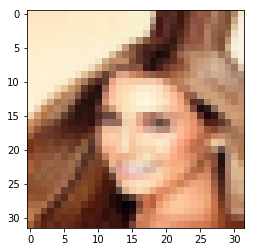

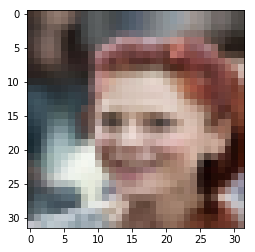

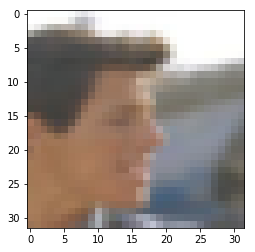

In [5]:
desired_attr = attr # index 12: Male, index 18: Smiling
print "shape of desired_attr: {}".format(desired_attr.shape)

# store training data and attr
train_samples = celeb_data, desired_attr.reshape((-1, attr_dim))

# cols = ["Black_Hair", "Blond_Hair", "Eyeglasses", "Male", "No_Beard", "Smiling", "Wearing_Hat", "Young"]
# check training data and feature
print("shape of one image: {}".format(train_samples[0][0].shape))
print("feature of the image: {}".format(train_samples[1][0]))
fig = plt.figure()
plt.imshow(train_samples[0][0])

print("shape of one image: {}".format(train_samples[0][1].shape))
print("feature of the image: {}".format(train_samples[1][1]))
fig = plt.figure()   
plt.imshow(train_samples[0][1])
print("shape of one image: {}".format(train_samples[0][2].shape))
print("feature of the image: {}".format(train_samples[1][2]))
fig = plt.figure()   
plt.imshow(train_samples[0][2])

## Implement GAN

* (1) define layer function
* (2) DCGAN

In [6]:
def viz_grid(Xs, padding):
    N, H, W, C = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size + 1)
    grid_width = W * grid_size + padding * (grid_size + 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = padding, H + padding
    for y in range(grid_size):
        x0, x1 = padding, W + padding
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

def conv2d(input, kernel_size, stride, num_filter, name = 'conv2d'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d(input, W, stride_shape, padding = 'SAME') + b

def conv2d_transpose(input, kernel_size, stride, num_filter, name = 'conv2d_transpose'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
        output_shape = tf.stack([tf.shape(input)[0], tf.shape(input)[1] * 2, tf.shape(input)[2] * 2, num_filter])

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d_transpose(input, W, output_shape, stride_shape, padding = 'SAME') + b

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def batch_norm(input, is_training):
    out = tf.contrib.layers.batch_norm(input, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def leaky_relu(input, alpha = 0.2):
    return tf.maximum(alpha * input, input)

In [15]:
class DCGAN(object):

    def __init__(self):
        self.num_epoch = 20
        self.batch_size = batchsize
        self.log_step = 50
        self.visualize_step = 200
        #self.code_size = 100 #64
        #self.attr_size = 2
        self.attr_size = attr_dim
        self.learning_rate = 8e-5
        self.vis_learning_rate = 1e-2
        self.recon_steps = 100
        self.actmax_steps = 100
        self.rec_rate = 0.5
        
        self._dis_called = False
        self._gen_called = False
    
        self.tracked_noise = tf.placeholder(tf.float32, [None, H_, W_, 3])

        self.real_input = tf.placeholder(tf.float32, [None, H_, W_, 3])
        self.real_label = tf.placeholder(tf.float32, [None, 1])
        self.fake_label = tf.placeholder(tf.float32, [None, 1])
        self.noise = tf.placeholder(tf.float32, [None, H_, W_, 3])
        self.attr = tf.placeholder(tf.float32, [None, self.attr_size])
        self.mismatch_attr = tf.placeholder(tf.float32, [None, self.attr_size])
        
        
        self.is_train = tf.placeholder(tf.bool)
        
        self.recon_sample = tf.placeholder(tf.float32, [1, 32, 32, 3])
        self.actmax_label = tf.placeholder(tf.float32, [1, 1])
        
        with tf.variable_scope('actmax'):
            self.actmax_attr = tf.placeholder(tf.float32, [1, self.attr_size])
#             tf.get_variable('actmax_code', [1, self.attr_size])
            self.actmax_code = tf.get_variable('actmax_code', [1, H_, W_, 3],
                                               initializer = tf.constant_initializer(0.0))
        
        self._init_ops()

    def _discriminator(self, inputs, attr_):
        # We have multiple instances of the discriminator in the same computation graph,
        # so set variable sharing if this is not the first invocation of this function.
        with tf.variable_scope('dis', reuse = self._dis_called):
            self._dis_called = True
            print inputs
            attr_ = tf.tile(tf.expand_dims(tf.tile(tf.expand_dims(attr_, 1), [1, 32, 1]), 1), [1, 32, 1, 1])
            print "attr_: {}".format(attr_)
            inputs = tf.concat([inputs, attr_], axis = 3)
            print "inputs: {}".format(inputs)
            dis_conv1 = conv2d(inputs, 4, 2, 32, 'conv1')
            dis_lrelu1 = leaky_relu(dis_conv1)
            dis_conv2 = conv2d(dis_lrelu1, 4, 2, 64, 'conv2')
            dis_batchnorm2 = batch_norm(dis_conv2, self.is_train)
            dis_lrelu2 = leaky_relu(dis_batchnorm2)
            dis_conv3 = conv2d(dis_lrelu2, 4, 2, 128, 'conv3')
            dis_batchnorm3 = batch_norm(dis_conv3, self.is_train)
            dis_lrelu3 = leaky_relu(dis_batchnorm3)
            dis_reshape3 = tf.reshape(dis_lrelu3, [-1, 4 * 4 * 128])
            # dis_addAttr3 = tf.concat([dis_reshape3, attr_], axis = 1)
            dis_fc4 = fc(dis_reshape3, 1, 'fc4')
            dis_prob = tf.nn.sigmoid(dis_fc4)
            return tf.reduce_mean(dis_prob), dis_fc4

    def _generator(self, noise, attr_):
        with tf.variable_scope('gen', reuse = self._gen_called):
            self._gen_called = True
            
#             attr_ = tf.tile(tf.expand_dims(tf.tile(tf.expand_dims(attr_, 1), [1, 32, 1]), 1), [1, 32, 1, 1])
#             print "gen_attr_ dim: {}".format(attr_)
#             noise_attr = tf.concat([noise, attr_], axis = 3)
#             print "gen_input dim: {}".format(noise)
#             inputs = tf.reshape(noise_attr, [-1, H_*W_*int(noise_attr.shape[3])])
#             print "gen_flatten dim: {}".format(inputs)
            noise_flat = tf.reshape(noise, [-1, H_*W_*int(noise.shape[3])])
            
            attr_ = tf.reshape(attr_, [-1, int(attr_.shape[1]), 1])
            attr_ = tf.tile(attr_, [1, 1, 10])
            attr_ = tf.reshape(attr_, [-1, 10 * int(attr_.shape[1])])
            print "gen_attr_ dim: {}".format(attr_)
            
            noise_attr = tf.concat([noise_flat, attr_], axis = 1)
            gen_fc1 = fc(noise_attr, 4 * 4 * 128, 'fc1')
            gen_reshape1 = tf.reshape(gen_fc1, [-1, 4, 4, 128])
            gen_batchnorm1 = batch_norm(gen_reshape1, self.is_train)
            gen_lrelu1 = leaky_relu(gen_batchnorm1)
            gen_conv2 = conv2d_transpose(gen_lrelu1, 5, 2, 64, 'conv2')
            gen_batchnorm2 = batch_norm(gen_conv2, self.is_train)
            gen_lrelu2 = leaky_relu(gen_batchnorm2)
            gen_conv3 = conv2d_transpose(gen_lrelu2, 5, 2, 32, 'conv3')
            gen_batchnorm3 = batch_norm(gen_conv3, self.is_train)
            gen_lrelu3 = leaky_relu(gen_batchnorm3)
            gen_conv4 = conv2d_transpose(gen_lrelu3, 5, 2, 3, 'conv4')
            gen_sigmoid4 = tf.sigmoid(gen_conv4)
            return gen_sigmoid4

    def _loss(self, labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)

    def _reconstruction_L1loss(self, generated, target):
        loss = tf.abs(generated - target)
        return tf.reduce_mean(loss)
    
    def _reconstruction_L2loss(self, generated, target):
        loss = tf.nn.l2_loss(generated - target)
        return tf.reduce_mean(loss)
    
    # Define operations
    def _init_ops(self):
        
        self.fake_samples_op = self._generator(self.noise, self.attr)
        self.D_fake_prob, D_fake = self._discriminator(self.fake_samples_op, self.attr)
        self.D_real_prob, D_real = self._discriminator(self.real_input, self.attr)
        self.D_mis_prob, D_mismatch = self._discriminator(self.real_input, self.mismatch_attr)
        
        self.dis_loss_op = self._loss(self.real_label, D_real) + self._loss(self.fake_label, D_fake) + self._loss(self.fake_label, D_mismatch)
        self.gen_loss_op = self._loss(self.real_label, D_fake)
        self.recon_loss_op = self.rec_rate * self._reconstruction_L1loss(self.noise, self.fake_samples_op)
        
        all_vars = tf.trainable_variables()

        d_var = [v for v in all_vars if v.name.startswith('dis')]
        g_var = [v for v in all_vars if v.name.startswith('gen')]
        
        # print the var status to check var
        import tensorflow.contrib.slim as slim
        print("********* d_var ********** ")
        slim.model_analyzer.analyze_vars(d_var, print_info=True)
        print("********* g_var ********** ") 
        slim.model_analyzer.analyze_vars(g_var, print_info=True)

        dis_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.dis_train_op = dis_optimizer.minimize(self.dis_loss_op, var_list = d_var)
        
        gen_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.gen_train_op = gen_optimizer.minimize(self.gen_loss_op, var_list = g_var)
        
        recon_optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.reconstruct_op = recon_optimizer.minimize(self.recon_loss_op, var_list = g_var)
        
#         ##
#         self.actmax_sample_op = self._generator(self.actmax_code, self.actmax_attr)
#         actmax_dis = self._discriminator(self.actmax_sample_op, self.actmax_attr)
#         self.actmax_loss_op = self._loss(self.actmax_label, actmax_dis)

#         actmax_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
#         self.actmax_op = actmax_optimizer.minimize(self.actmax_loss_op, var_list = [self.actmax_code])
        
#         ##
#         self.recon_loss_op = self._reconstruction_loss(self.actmax_sample_op, self.recon_sample)
        
#         recon_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
#         self.reconstruct_op = recon_optimizer.minimize(self.recon_loss_op, var_list = [self.actmax_code])
    # Pretrain 
    # Training function
    def train(self, sess, train_samples, sample_features, load_flag = False):
        if not load_flag:
            sess.run(tf.global_variables_initializer())
    
        train_data, train_attr= train_samples
        num_train = train_data.shape[0]
        step = 0
        
        # smooth the loss curve so that it does not fluctuate too much
        smooth_factor = 0.95
        plot_dis_s = 0
        plot_gen_s = 0
        plot_recon_s = 0
        plot_ws = 0
        
        plot_dis_f = 0
        plot_dis_r = 0
        plot_dis_m = 0
        
        dis_losses = []
        fakes = []
        reals = []
        mismatchs = []
        gen_losses = []
        recon_losses = []
        
        import copy
        update_ratio = 2
        gen_loss = 0.0
        dis_loss = 0.0
        recon_loss = 0.0
        for epoch in range(self.num_epoch):
            for i in range(num_train // self.batch_size):
                step += 1
                                                          
                batch_data = train_data[i * self.batch_size : (i + 1) * self.batch_size]
                batch_attr = train_attr[i * self.batch_size : (i + 1) * self.batch_size]
#                 noise = np.random.normal(0, 1, [self.batch_size, H_, W_, 3])
                if i == 0:
                    noise = batch_data[0:self.batch_size]
#                     noise = np.random.normal(0, 1, [self.batch_size, H_, W_, 3])
                else:
                    noise = gen_out
                
                
                if i % 20 == 0:
                    print str(epoch) +" "+ str(i)
                    fig = plt.figure(figsize = (6, 6)) 
                    ax1 = plt.subplot(111)
                    image = viz_grid(noise, 1)
                    ax1.imshow(image)
                    plt.show()
                
                zeros = np.zeros([self.batch_size, 1])
                ones = np.ones([self.batch_size, 1])
                mismatch_attr = copy.deepcopy(batch_attr)
                for i in range(len(mismatch_attr)):
                    """
                    print("before")
                    print(mismatch_attr[i])
                    print(batch_attr[i])
                    """
                    for j in range(len(mismatch_attr[i])):
                        """
                        if i == 0:
                            print("before")
                            print(mismatch_attr[i][j])
                            print(batch_attr[i][j])
                        """
                        if mismatch_attr[i][j] == 0:
                            mismatch_attr[i][j] = 1
                        else:
                            mismatch_attr[i][j] = 0
                        """
                        if i == 0:
                            print("after")
                            print(mismatch_attr[i][j])
                            print(batch_attr[i][j])
                        """
                    """
                    print("after")
                    print(mismatch_attr[i])
                    print(batch_attr[i])
                    """
#                 print "attr shape: {} {}".format(batch_attr.shape, mismatch_attr.shape)
                if batch_attr.shape[0] != self.batch_size:
                    print "Error: attr shape not match: attr shape {}, batch size {}".format(batch_attr.shape, self.batch_size)
                    continue
                dis_feed_dict = {self.real_input: batch_data, 
                                 self.noise: noise, 
                                 self.attr: batch_attr,
                                 self.mismatch_attr: mismatch_attr,
                                 self.real_label: ones, 
                                 self.fake_label: zeros, 
                                 self.is_train:True}
                
                gen_feed_dict = {self.noise: noise, 
                                 self.attr: batch_attr,
                                 self.real_label: ones, 
                                 self.is_train: True}
                """
                if i % update_ratio == 0:
                    _, dis_loss = sess.run([self.dis_train_op, self.dis_loss_op], feed_dict = dis_feed_dict)
                else:
                    _, gen_loss = sess.run([self.gen_train_op, self.gen_loss_op], feed_dict = gen_feed_dict)
                """
                _, dis_loss, dis_fake, dis_real, dis_mis = sess.run([self.dis_train_op, self.dis_loss_op, self.D_fake_prob,
                                                                    self.D_real_prob, self.D_mis_prob], feed_dict = dis_feed_dict)
                if i == 0:
                    _, gen_loss, gen_out = sess.run([self.gen_train_op, self.gen_loss_op, self.fake_samples_op], feed_dict = gen_feed_dict)
                else:
                    _, gen_loss, gen_out, recon_loss, _ = sess.run([self.gen_train_op, self.gen_loss_op, self.fake_samples_op, self.recon_loss_op, self.reconstruct_op], feed_dict = gen_feed_dict)
                
                plot_dis_s = plot_dis_s * smooth_factor + dis_loss * (1 - smooth_factor)
                plot_gen_s = plot_gen_s * smooth_factor + gen_loss * (1 - smooth_factor)
                plot_recon_s = plot_recon_s * smooth_factor + recon_loss * (1 - smooth_factor)
                plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
                dis_losses.append(plot_dis_s / plot_ws)
                gen_losses.append(plot_gen_s / plot_ws)
                recon_losses.append(plot_recon_s / plot_ws)
                
                plot_dis_f = plot_dis_f * smooth_factor + dis_fake * (1 - smooth_factor)
                plot_dis_r = plot_dis_r * smooth_factor + dis_real * (1 - smooth_factor)
                plot_dis_m = plot_dis_m * smooth_factor + dis_mis * (1 - smooth_factor)
                fakes.append(plot_dis_f / plot_ws)
                reals.append(plot_dis_r / plot_ws)
                mismatchs.append(plot_dis_m / plot_ws)

                if step % self.log_step == 0:
                    print('Iteration {0}: dis loss = {1:.4f}, gen loss = {2:.4f}, recon loss = {2:.4f}'.format(step, dis_loss, gen_loss, recon_loss))
    
            
            if not os.path.exists(MODEL_DIR):
                os.mkdir(MODEL_DIR)
                
            if not os.path.exists(OUTPUT_DIR):
                os.mkdir(OUTPUT_DIR)
                
            filename = OUTPUT_DIR + '%d_%d.png' % (epoch,i)
            
            n = 50 # random number
            self.tracked_noise = train_data[n:n+64]
            fig = plt.figure(figsize = (8, 8)) 
            ax0 = plt.subplot(111)
            image = viz_grid(self.tracked_noise, 1)
            ax0.imshow(image)
            plt.show()
            
            fig = plt.figure(figsize = (8, 8)) 
            ax1 = plt.subplot(111)
            image = viz_grid(self.generate(self.tracked_noise, sample_features), 1)
            scipy.misc.imsave(filename, image)
            ax1.imshow(image)
            plt.show()

            plt.plot(dis_losses)
            plt.title('discriminator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()
            
            plt.plot(fakes, label="fake", color="blue")
            plt.plot(reals, label="real", color="red")
            plt.plot(mismatchs, label="mismatch", color="green")
            plt.legend(['fake', 'real', 'mismatch'], loc='upper left')
            plt.title('D_fake_real_mis')
            plt.xlabel('iterations')
            plt.ylabel('prob')
            plt.show()

            plt.plot(gen_losses)
            plt.title('generator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()
            
            plt.plot(recon_losses)
            plt.title('reconstruction loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()
            
            dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
            gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
            saver = tf.train.Saver(dis_var_list + gen_var_list)
            saver.save(sess, MODEL_DIR + 'dcgan_%d' % epoch)

    # Find the reconstruction of one input sample
    def reconstruct_one_sample(self, sample):
        ##
        code = np.random.random([1, H_, W_, 3])
        actmax_init_val = tf.convert_to_tensor(code, dtype = tf.float32)
        
        sess.run(self.actmax_code.assign(actmax_init_val))
        last_reconstruction = None
        last_loss = None
        for i in range(self.recon_steps):
        
            ##
            recon_feed_dict = {self.recon_sample: sample, 
                               self.is_train: False}
            
            run_ops = [self.recon_loss_op, self.reconstruct_op, self.actmax_sample_op]
            last_loss, _, last_reconstruction = sess.run(run_ops, feed_dict = recon_feed_dict)
        return last_loss, last_reconstruction

    # Find the reconstruction of a batch of samples
    def reconstruct(self, samples):
        reconstructions = np.zeros(samples.shape)
        total_loss = 0
        for i in range(samples.shape[0]):
            loss, reconstructions[i:i+1] = self.reconstruct_one_sample(samples[i:i+1])
            total_loss += loss
        return total_loss / samples.shape[0], reconstructions

    # Generates a single sample from input code
    def generate_one_sample(self, code, attr_):

        gen_vis_feed_dict = {self.noise: code, 
                             self.attr: attr_, 
                             self.is_train: False}
        
        generated = sess.run(self.fake_samples_op, feed_dict = gen_vis_feed_dict)
        return generated

    # Generates samples from input batch of codes
    def generate(self, codes, attr_):
        generated = np.zeros((codes.shape[0], H_, W_, 3))
        for i in range(codes.shape[0]):
            generated[i:i+1] = self.generate_one_sample(codes[i:i+1], attr_)
        return generated

    # Perform activation maximization on one initial code
    def actmax_one_sample(self, initial_code):
        
        ##
        actmax_init_val = tf.convert_to_tensor(initial_code, dtype = tf.float32)
        sess.run(self.actmax_code.assign(actmax_init_val))
        for i in range(self.actmax_steps):
            actmax_feed_dict = {
                self.actmax_label: np.ones([1, 1]),
                self.is_train: False
            }
            _, last_actmax = sess.run([self.actmax_op, self.actmax_sample_op], feed_dict = actmax_feed_dict)
        return last_actmax

    # Perform activation maximization on a batch of different initial codes
    def actmax(self, initial_codes):
        actmax_results = np.zeros((initial_codes.shape[0], 32, 32, 3))
        for i in range(initial_codes.shape[0]):
            actmax_results[i:i+1] = self.actmax_one_sample(initial_codes[i:i+1])
        return actmax_results.clip(0, 1)

## Training
* start to train
* save the trained model at 'model/dcgan' 
* save output image & loss curve at OUTPUT_DIR


gen_attr_ dim: Tensor("gen/Reshape_2:0", shape=(?, 20), dtype=float32, device=/device:CPU:0)
Tensor("gen/Sigmoid:0", shape=(?, ?, ?, 3), dtype=float32, device=/device:CPU:0)
attr_: Tensor("dis/Tile_1:0", shape=(?, 32, 32, 2), dtype=float32, device=/device:CPU:0)
inputs: Tensor("dis/concat:0", shape=(?, 32, 32, 5), dtype=float32, device=/device:CPU:0)
Tensor("Placeholder_1:0", shape=(?, 32, 32, 3), dtype=float32, device=/device:CPU:0)
attr_: Tensor("dis_1/Tile_1:0", shape=(?, 32, 32, 2), dtype=float32, device=/device:CPU:0)
inputs: Tensor("dis_1/concat:0", shape=(?, 32, 32, 5), dtype=float32, device=/device:CPU:0)
Tensor("Placeholder_1:0", shape=(?, 32, 32, 3), dtype=float32, device=/device:CPU:0)
attr_: Tensor("dis_2/Tile_1:0", shape=(?, 32, 32, 2), dtype=float32, device=/device:CPU:0)
inputs: Tensor("dis_2/concat:0", shape=(?, 32, 32, 5), dtype=float32, device=/device:CPU:0)
********* d_var ********** 
---------
Variables: name (type shape) [size]
---------
dis/conv1/w:0 (float32_ref 

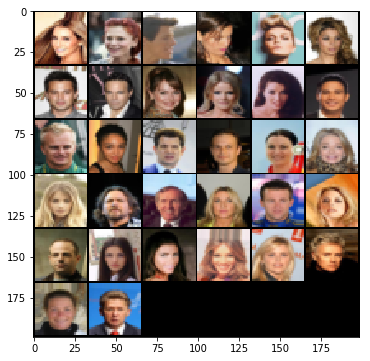

0 20


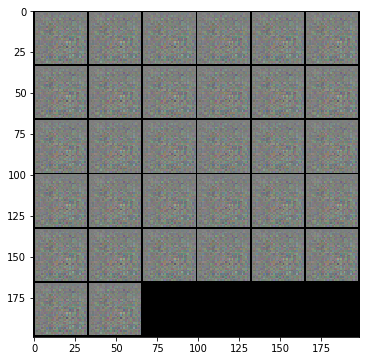

0 40


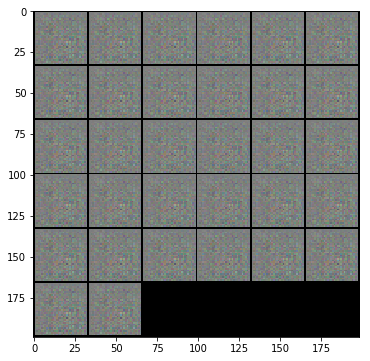

Iteration 50: dis loss = 1.6485, gen loss = 1.6643, recon loss = 1.6643
0 60


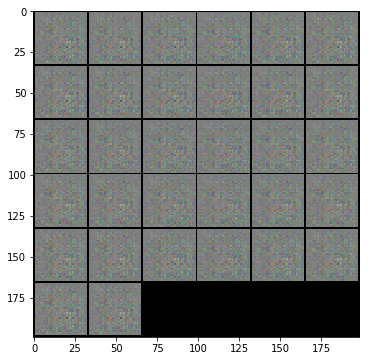

0 80


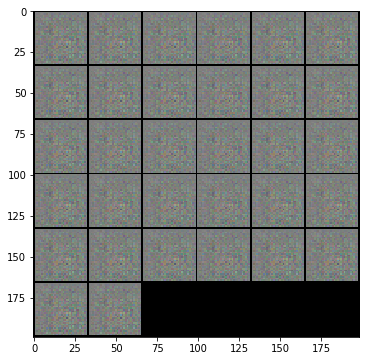

Iteration 100: dis loss = 1.1185, gen loss = 2.0902, recon loss = 2.0902
0 100


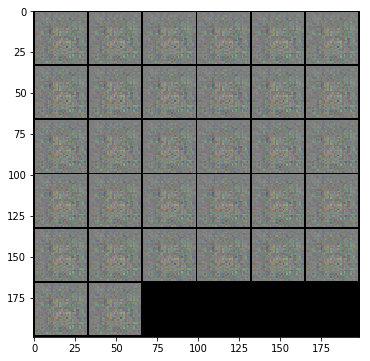

0 120


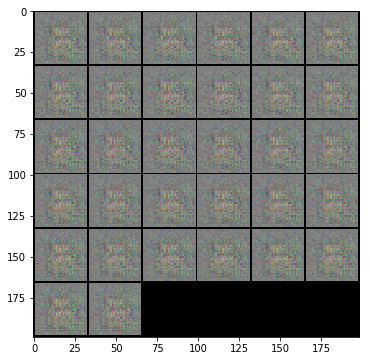

0 140


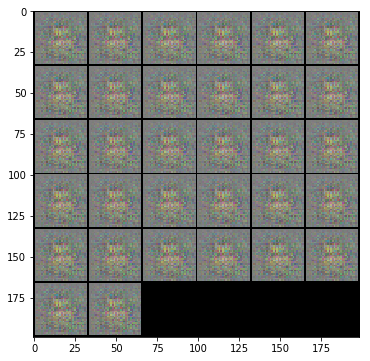

Iteration 150: dis loss = 1.2355, gen loss = 3.3242, recon loss = 3.3242
0 160


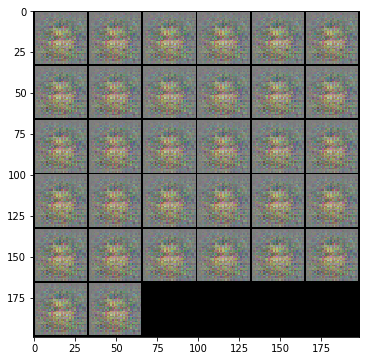

0 180


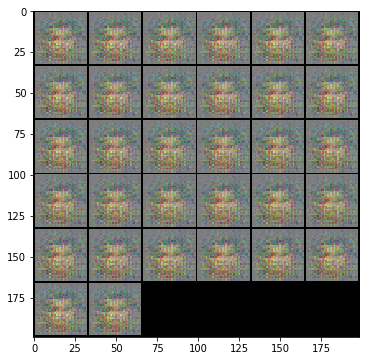

Iteration 200: dis loss = 0.6198, gen loss = 2.8948, recon loss = 2.8948
0 200


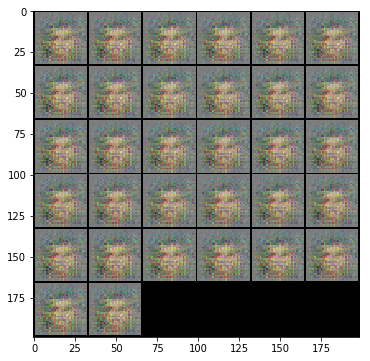

0 220


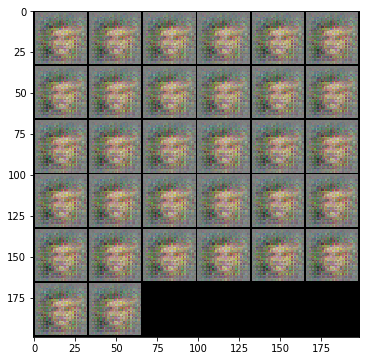

0 240


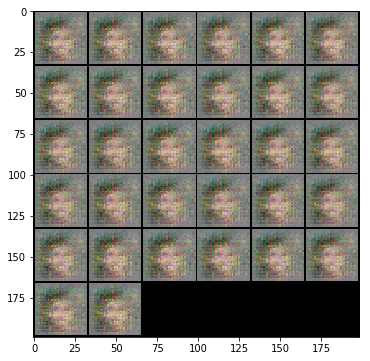

Iteration 250: dis loss = 0.7654, gen loss = 3.6813, recon loss = 3.6813
0 260


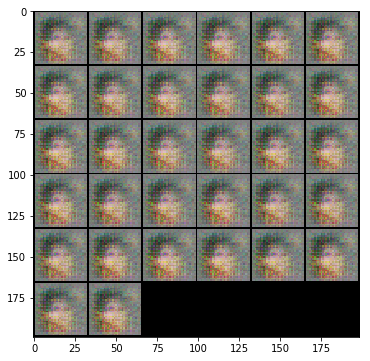

0 280


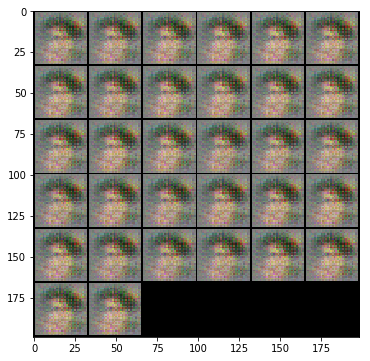

Iteration 300: dis loss = 1.1734, gen loss = 3.7277, recon loss = 3.7277
0 300


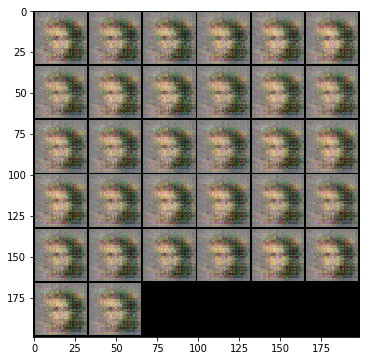

0 320


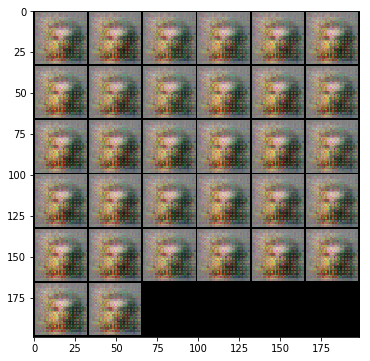

0 340


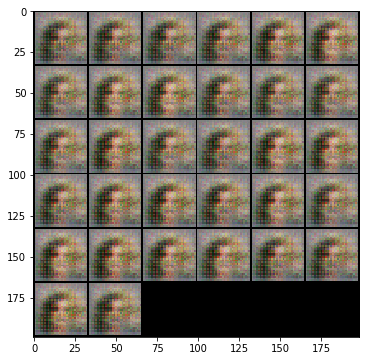

Iteration 350: dis loss = 0.7964, gen loss = 3.3147, recon loss = 3.3147
0 360


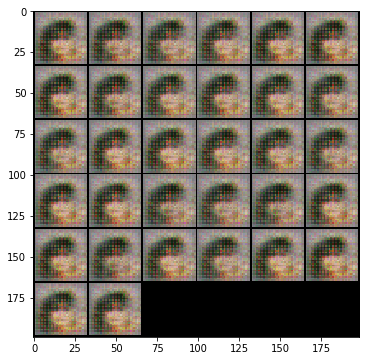

0 380


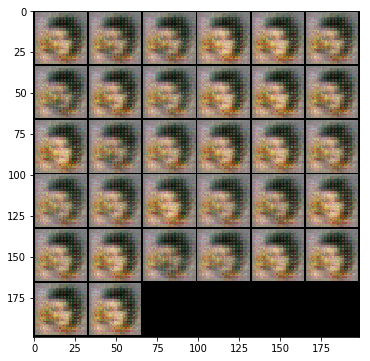

Iteration 400: dis loss = 0.7892, gen loss = 2.9784, recon loss = 2.9784
0 400


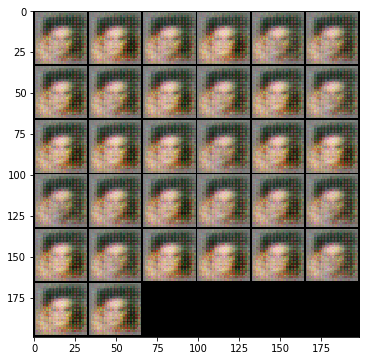

0 420


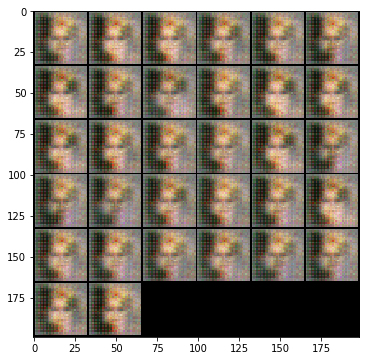

0 440


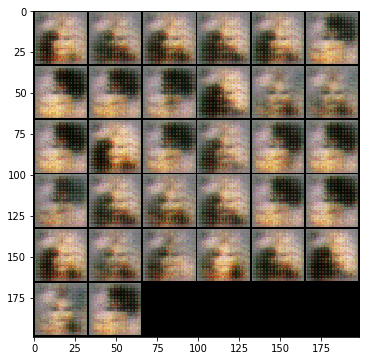

Iteration 450: dis loss = 0.6159, gen loss = 2.4909, recon loss = 2.4909
0 460


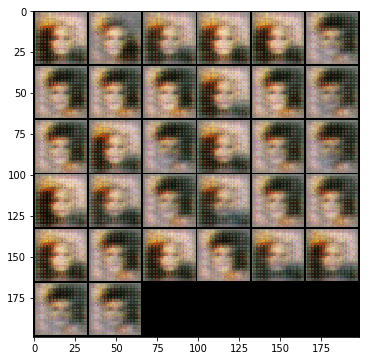

0 480


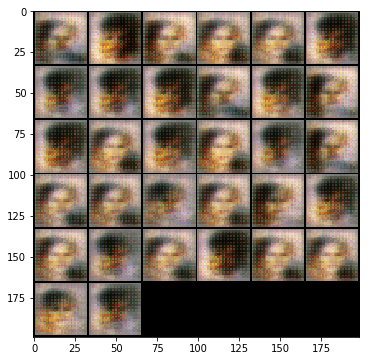

Iteration 500: dis loss = 0.7148, gen loss = 2.5002, recon loss = 2.5002
0 500


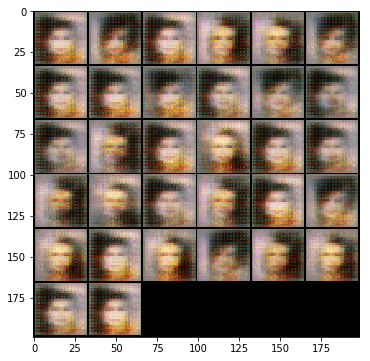

0 520


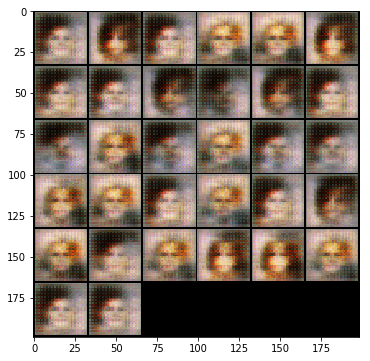

0 540


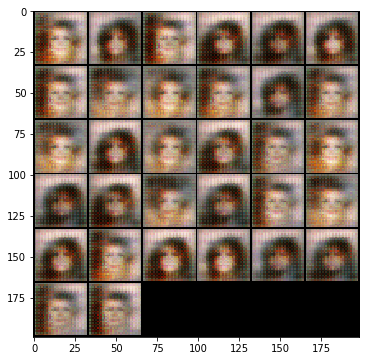

Iteration 550: dis loss = 1.4176, gen loss = 1.6864, recon loss = 1.6864
0 560


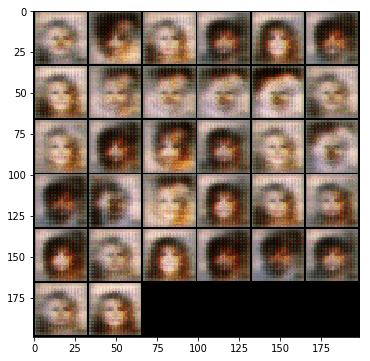

0 580


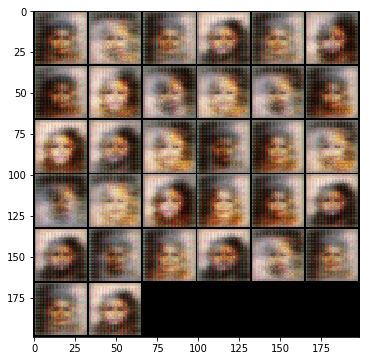

Iteration 600: dis loss = 2.7978, gen loss = 2.2355, recon loss = 2.2355
0 600


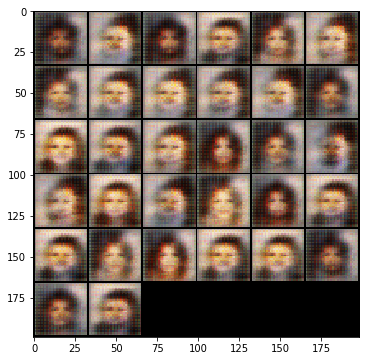

0 620


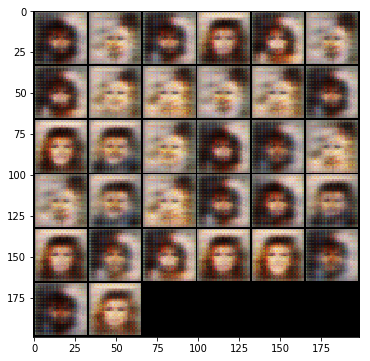

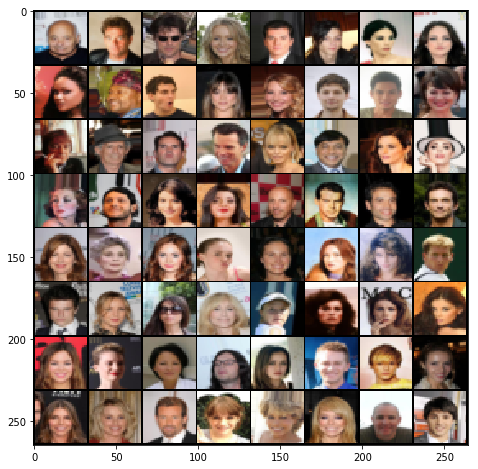

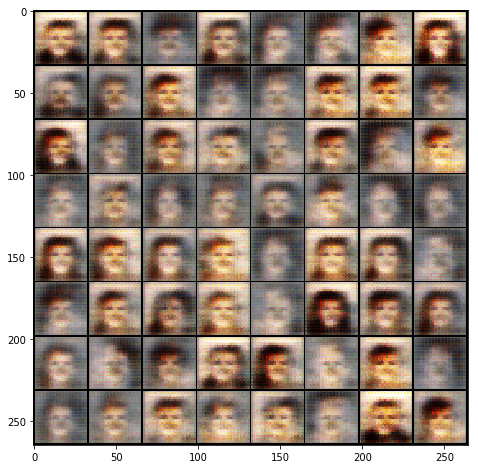

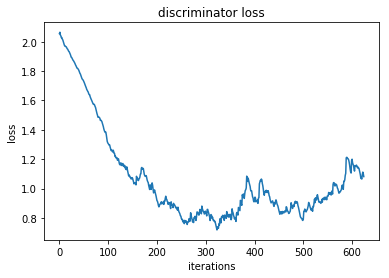

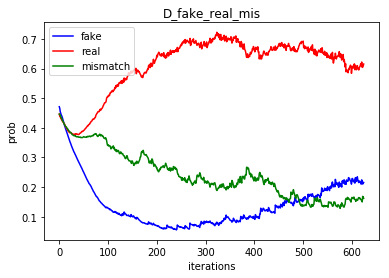

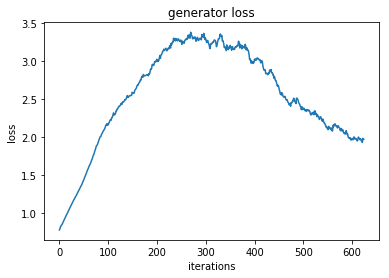

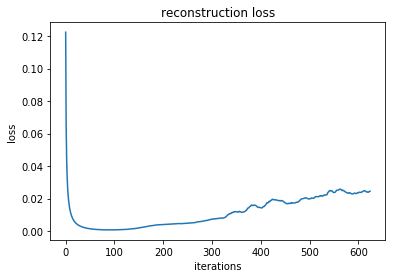

1 0


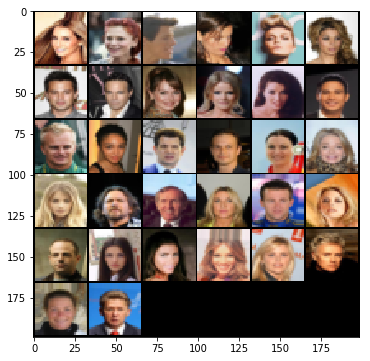

1 20


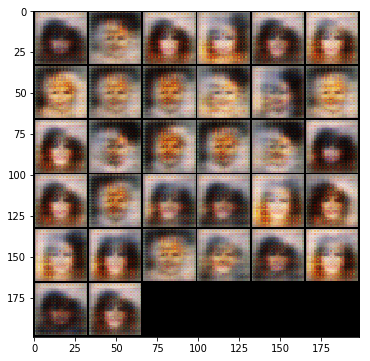

Iteration 650: dis loss = 1.0514, gen loss = 1.8433, recon loss = 1.8433
1 40


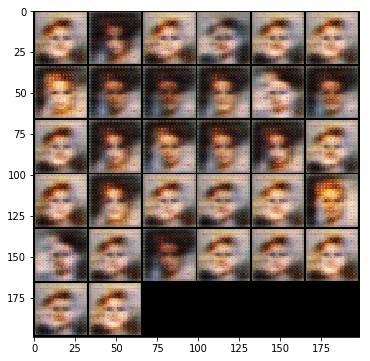

1 60


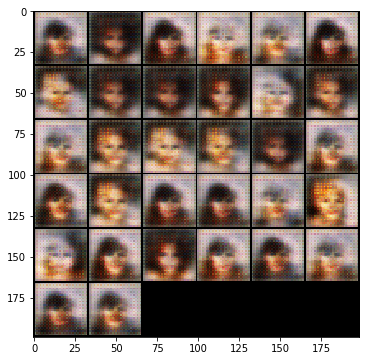

Iteration 700: dis loss = 1.6590, gen loss = 1.4108, recon loss = 1.4108
1 80


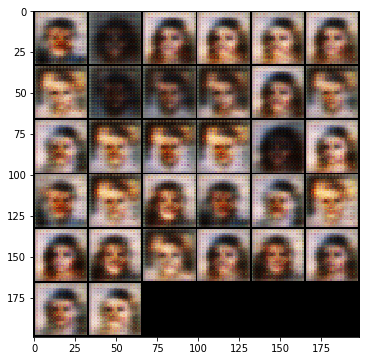

1 100


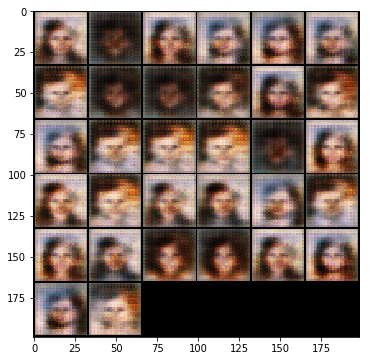

1 120


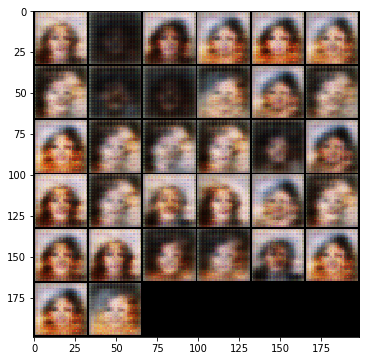

Iteration 750: dis loss = 1.4994, gen loss = 1.2051, recon loss = 1.2051
1 140


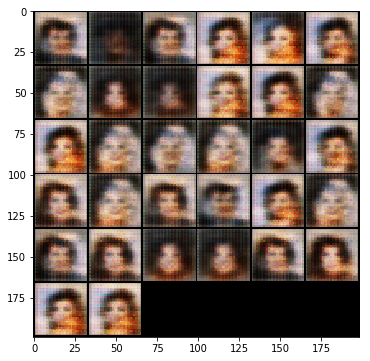

1 160


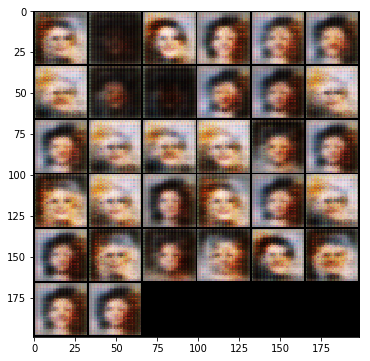

Iteration 800: dis loss = 1.2901, gen loss = 1.0308, recon loss = 1.0308
1 180


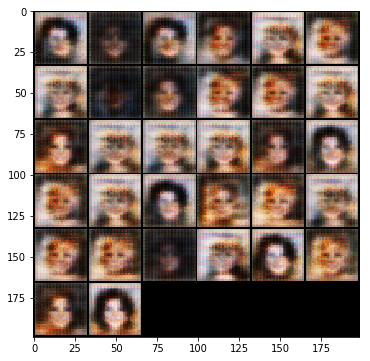

1 200


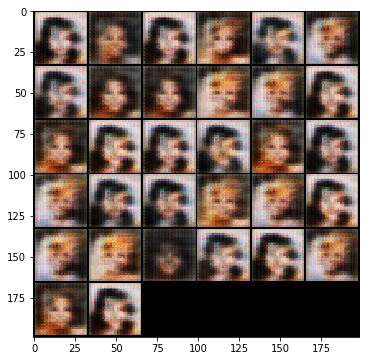

1 220


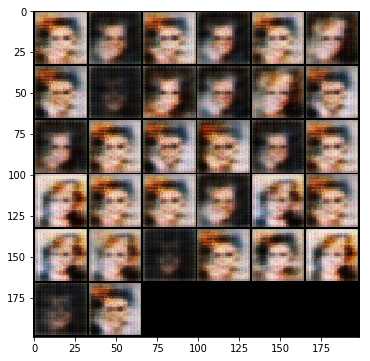

Iteration 850: dis loss = 2.9766, gen loss = 0.9327, recon loss = 0.9327
1 240


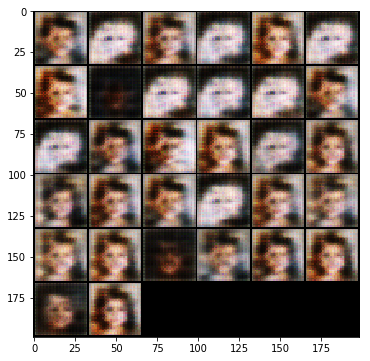

1 260


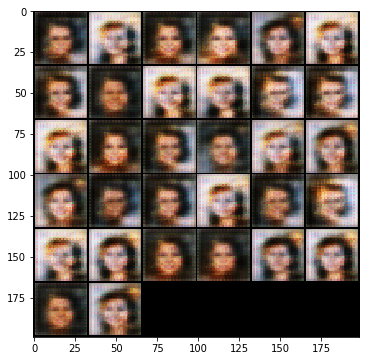

Iteration 900: dis loss = 1.5252, gen loss = 1.1049, recon loss = 1.1049
1 280


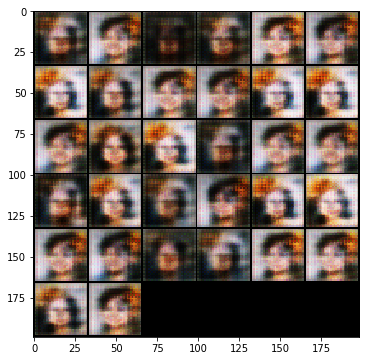

KeyboardInterrupt: 

In [16]:
tf.reset_default_graph()

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dcgan.train(sess, train_samples, sample_features)
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.save(sess, 'model_1126/dcgan')


## Reloading model and Training
* load the trained model at 'model/dcgan'
* Turn load_flag = True

In [ ]:
tf.reset_default_graph()

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.restore(sess, 'model_1126/dcgan')
        dcgan.train(sess, train_samples, sample_features, load_flag = True)
        

## Imshow Sample features

gen_attr_ dim: Tensor("gen/Reshape_2:0", shape=(?, 20), dtype=float32, device=/device:CPU:0)
Tensor("gen/Sigmoid:0", shape=(?, ?, ?, 3), dtype=float32, device=/device:CPU:0)
attr_: Tensor("dis/Tile_1:0", shape=(?, 32, 32, 2), dtype=float32, device=/device:CPU:0)
inputs: Tensor("dis/concat:0", shape=(?, 32, 32, 5), dtype=float32, device=/device:CPU:0)
Tensor("Placeholder_1:0", shape=(?, 32, 32, 3), dtype=float32, device=/device:CPU:0)
attr_: Tensor("dis_1/Tile_1:0", shape=(?, 32, 32, 2), dtype=float32, device=/device:CPU:0)
inputs: Tensor("dis_1/concat:0", shape=(?, 32, 32, 5), dtype=float32, device=/device:CPU:0)
Tensor("Placeholder_1:0", shape=(?, 32, 32, 3), dtype=float32, device=/device:CPU:0)
attr_: Tensor("dis_2/Tile_1:0", shape=(?, 32, 32, 2), dtype=float32, device=/device:CPU:0)
inputs: Tensor("dis_2/concat:0", shape=(?, 32, 32, 5), dtype=float32, device=/device:CPU:0)
********* d_var ********** 
---------
Variables: name (type shape) [size]
---------
dis/conv1/w:0 (float32_ref 

INFO:tensorflow:Restoring parameters from model_1126/dcgan


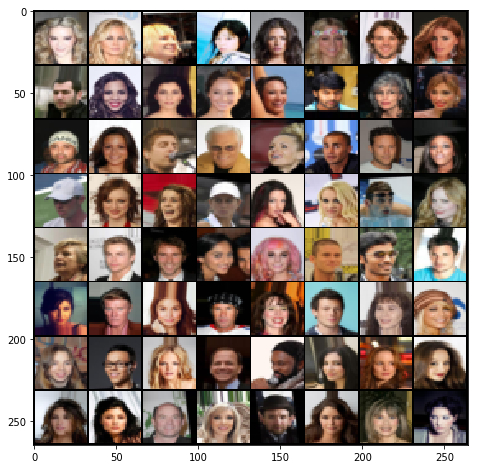

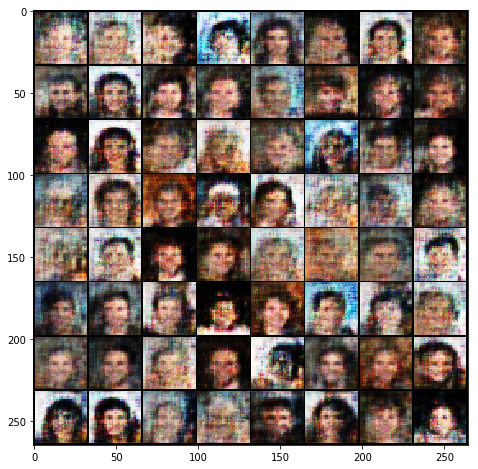

In [9]:
tf.reset_default_graph()

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.restore(sess, 'model_1126/dcgan')

        n = np.random.randint(0, high = num_of_img - 64)
        fig = plt.figure(figsize = (8, 8)) 
        ax0 = plt.subplot(111)
        image = viz_grid(celeb_data[n:n+64], 1)
        ax0.imshow(image)
        plt.show()

        fig = plt.figure(figsize = (8, 8)) 
        ax1 = plt.subplot(111)
        image = viz_grid(dcgan.generate(celeb_data[n:n+64], sample_features), 1)
        ax1.imshow(image)
        plt.show()

gen_attr_ dim: Tensor("gen/Reshape_2:0", shape=(?, 20), dtype=float32, device=/device:CPU:0)
Tensor("gen/Sigmoid:0", shape=(?, ?, ?, 3), dtype=float32, device=/device:CPU:0)
attr_: Tensor("dis/Tile_1:0", shape=(?, 32, 32, 2), dtype=float32, device=/device:CPU:0)
inputs: Tensor("dis/concat:0", shape=(?, 32, 32, 5), dtype=float32, device=/device:CPU:0)
Tensor("Placeholder_1:0", shape=(?, 32, 32, 3), dtype=float32, device=/device:CPU:0)
attr_: Tensor("dis_1/Tile_1:0", shape=(?, 32, 32, 2), dtype=float32, device=/device:CPU:0)
inputs: Tensor("dis_1/concat:0", shape=(?, 32, 32, 5), dtype=float32, device=/device:CPU:0)
Tensor("Placeholder_1:0", shape=(?, 32, 32, 3), dtype=float32, device=/device:CPU:0)
attr_: Tensor("dis_2/Tile_1:0", shape=(?, 32, 32, 2), dtype=float32, device=/device:CPU:0)
inputs: Tensor("dis_2/concat:0", shape=(?, 32, 32, 5), dtype=float32, device=/device:CPU:0)
********* d_var ********** 
---------
Variables: name (type shape) [size]
---------
dis/conv1/w:0 (float32_ref 

INFO:tensorflow:Restoring parameters from model_1126/dcgan


original images from 2 to 66


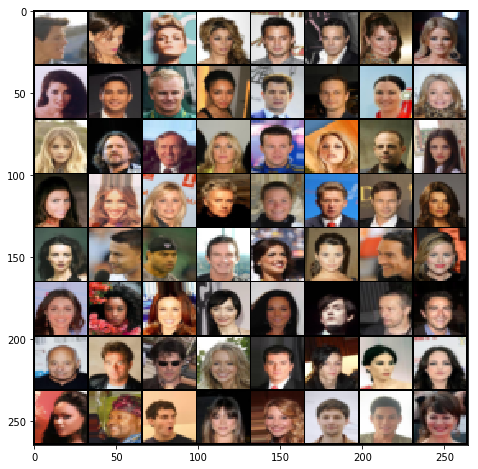

Male 


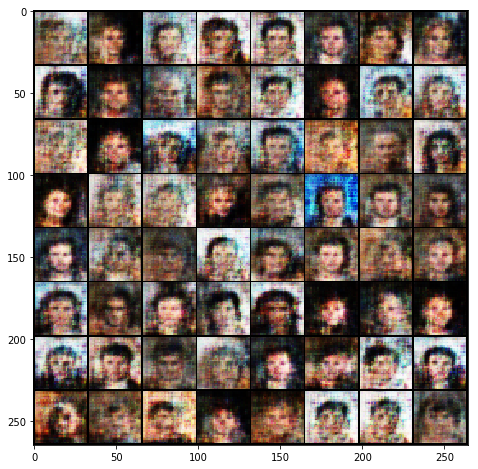

Male Smiling 


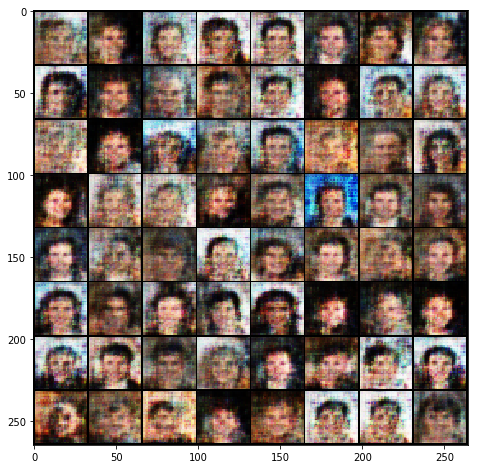

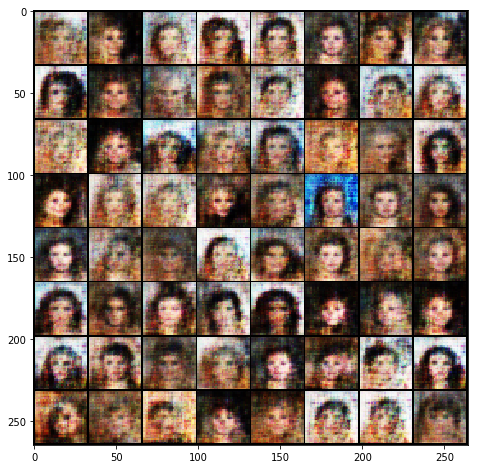

Smiling 


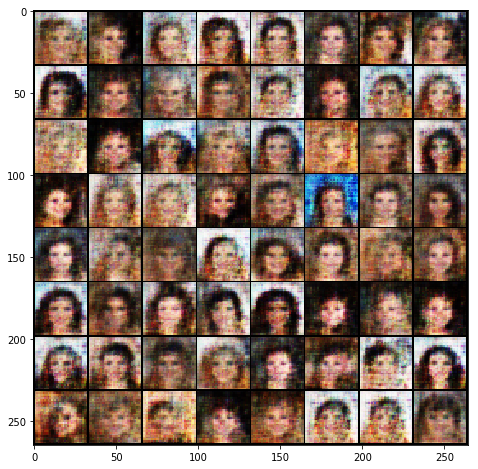

In [11]:

# cols = ["Black_Hair", "Blond_Hair", "Eyeglasses", "Male", "No_Beard", "Smiling", "Wearing_Hat", "Young"]
# Male, 1 # Smiling, 1
def createFeature(SampleFeature):
    size = len(SampleFeature)
    return np.array(SampleFeature).reshape((-1,size))

def printFeature(SampleFeature):
    cols = ["Male","Smiling"]
    size = len(SampleFeature[0])
    out = ""
    for i in xrange(size):
        if SampleFeature[0][i]:
            out = out + cols[i] + " "
    return out

# store sample feature
feature_samples = []
# Male, not Smile
feature_samples.append(createFeature([1, 0]))
# Male, Smiling
feature_samples.append(createFeature([1, 1]))
# Female, not Smile
feature_samples.append(createFeature([0, 0]))
# Female, Smiling
feature_samples.append(createFeature([0, 1]))


tf.reset_default_graph()

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.restore(sess, 'model_1126/dcgan')
        
        
        n = np.random.randint(0, high = num_of_img - 64)
        print "original images from {0} to {1}".format(n, n+64)
        
        fig = plt.figure(figsize = (8, 8)) 
        ax0 = plt.subplot(111)
        image = viz_grid(celeb_data[n:n+64], 1)
        ax0.imshow(image)
        plt.show()
        
        for ft in feature_samples:
            print printFeature(ft)
            fig = plt.figure(figsize = (8, 8)) 
            ax1 = plt.subplot(111)
            image = viz_grid(dcgan.generate(celeb_data[n:n+64], ft), 1)
            ax1.imshow(image)
            plt.show()




## Change input as image and modify attributes
* take one image from dataset as input
* feed into model

In [ ]:
tf.reset_default_graph()

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.restore(sess, 'model_1124/dcgan')
        
        inp = train_samples[0][0:64]
        
        fig = plt.figure(figsize = (8, 8)) 
        ax1 = plt.subplot(111)
        image = viz_grid(inp, 1)
        #scipy.misc.imsave(filename, image)
        ax1.imshow(image)
        plt.show()
        
        ft = createFeature([1,0])
        inp = train_samples[0][0:64]
        
        fig = plt.figure(figsize = (8, 8)) 
        ax1 = plt.subplot(111)
        
        image = viz_grid(dcgan.generate(inp, ft), 1)
        #scipy.misc.imsave(filename, image)
        ax1.imshow(image)
        plt.show()
        
        ft = createFeature([0,1])
        inp = train_samples[0][0:64]
        
        fig = plt.figure(figsize = (8, 8)) 
        ax1 = plt.subplot(111)
        
        image = viz_grid(dcgan.generate(inp, ft), 1)
        #scipy.misc.imsave(filename, image)
        ax1.imshow(image)
        plt.show()
        
        ft = createFeature([1,1])
        inp = train_samples[0][0:64]
        
        fig = plt.figure(figsize = (8, 8)) 
        ax1 = plt.subplot(111)
        
        image = viz_grid(dcgan.generate(inp, ft), 1)
        #scipy.misc.imsave(filename, image)
        ax1.imshow(image)
        plt.show()
        
        ft = createFeature([0,0])
        inp = train_samples[0][0:64]
        
        fig = plt.figure(figsize = (8, 8)) 
        ax1 = plt.subplot(111)
        
        image = viz_grid(dcgan.generate(inp, ft), 1)
        #scipy.misc.imsave(filename, image)
        ax1.imshow(image)
        plt.show()
        